Prevendo a qualidade sensorial de um vinho (nota 0 a 10) com base nas características físico-químicas e quais variáveis possuem maior influência na predição utilizando KNN + Undersampling

In [ ]:
!pip install --user scikit-learn imbalanced-learn pandas seaborn matplotlib pyarrow

In [31]:
# Manipulação e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e modelo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# Balanceamento
from imblearn.under_sampling import RandomUnderSampler

# Estilo
sns.set(style="whitegrid")

In [20]:
# Leitura do dataset
wine_quality = pd.read_parquet("data/processed/wine-quality.parquet")

# Criar variável alvo binária: qualidade boa (1) se nota > 5
wine_quality['good_quality'] = wine_quality['quality'].apply(lambda x: 1 if x > 5 else 0)

# Codificação da variável categórica 'type'
df_processed = pd.get_dummies(wine_quality, columns=['type'], drop_first=True, dtype=int)

df_processed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good_quality,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,1


Análise exploratória - distribuição das variáveis

<Figure size 1600x1000 with 0 Axes>

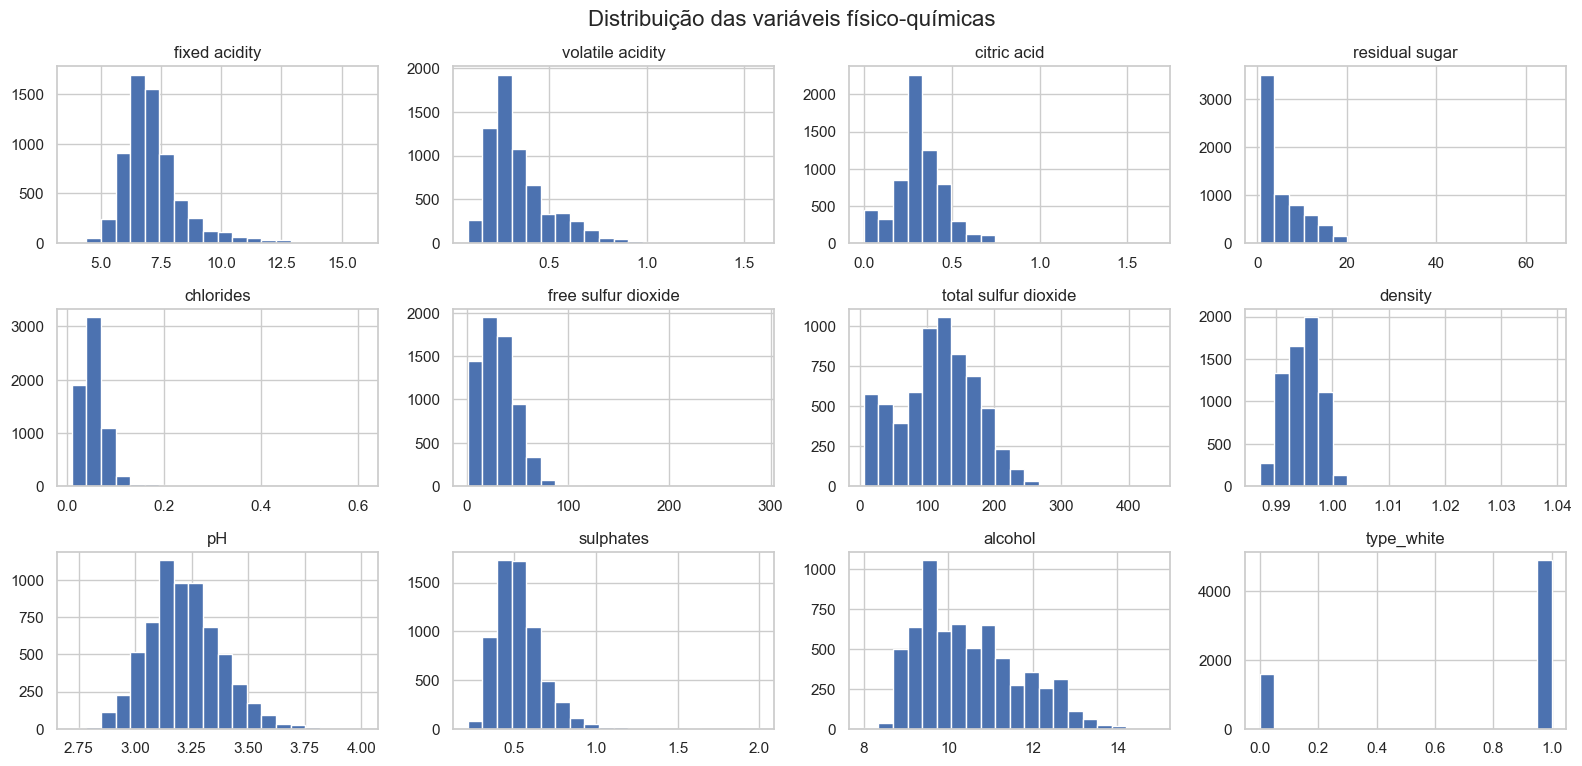

In [21]:
plt.figure(figsize=(16, 10))
df_processed.drop(columns=['quality', 'good_quality']).hist(bins=20, layout=(4, 4), figsize=(16, 10))
plt.suptitle('Distribuição das variáveis físico-químicas', fontsize=16)
plt.tight_layout()
plt.show()

Correlação entre as variáveis

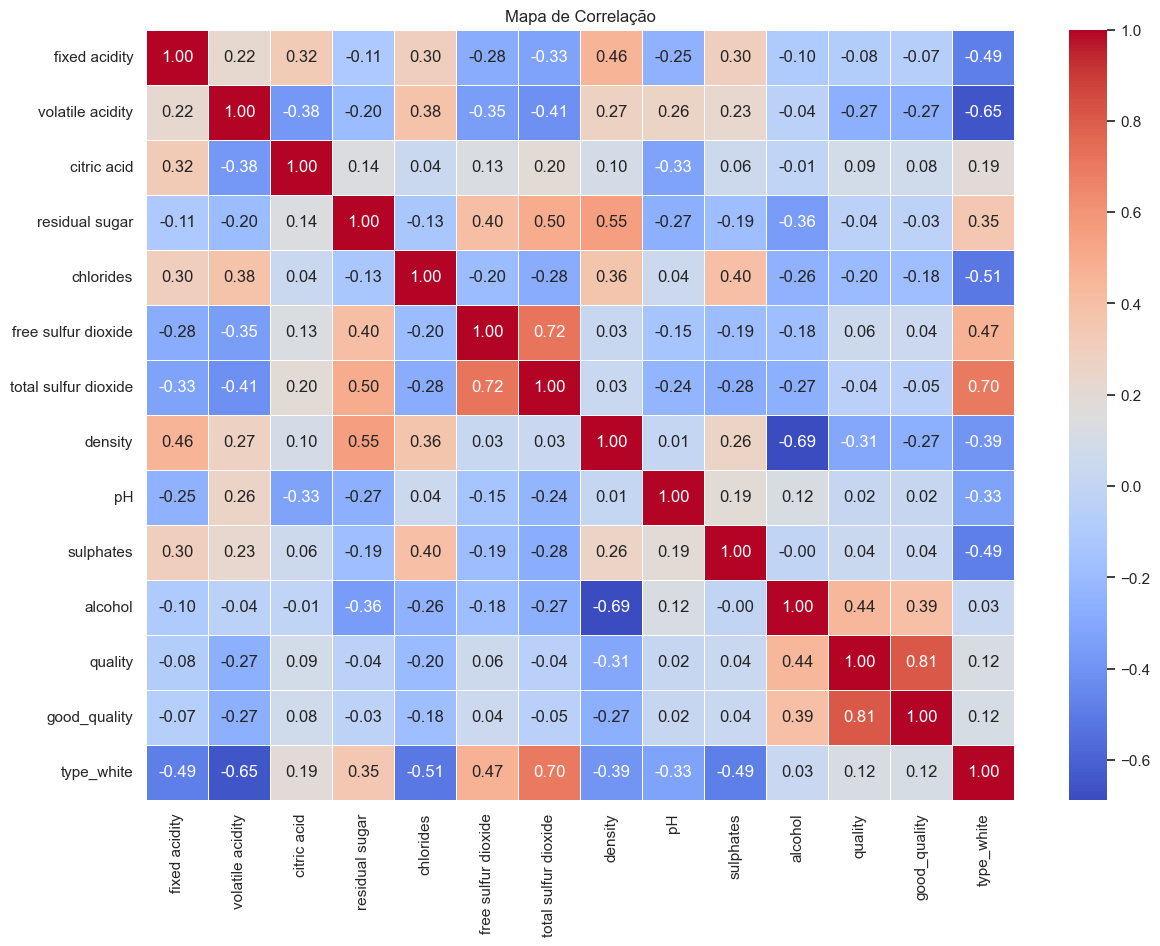

In [22]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_processed.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlação')
plt.show()

Separando features e alvo + escalonamento

In [23]:
features = df_processed.drop(['quality', 'good_quality'], axis=1).columns
X = df_processed[features]
y = df_processed['good_quality']

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

Dividindo treino/teste + undersampling

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

Importância das variáveis - F-test e Mutual Info

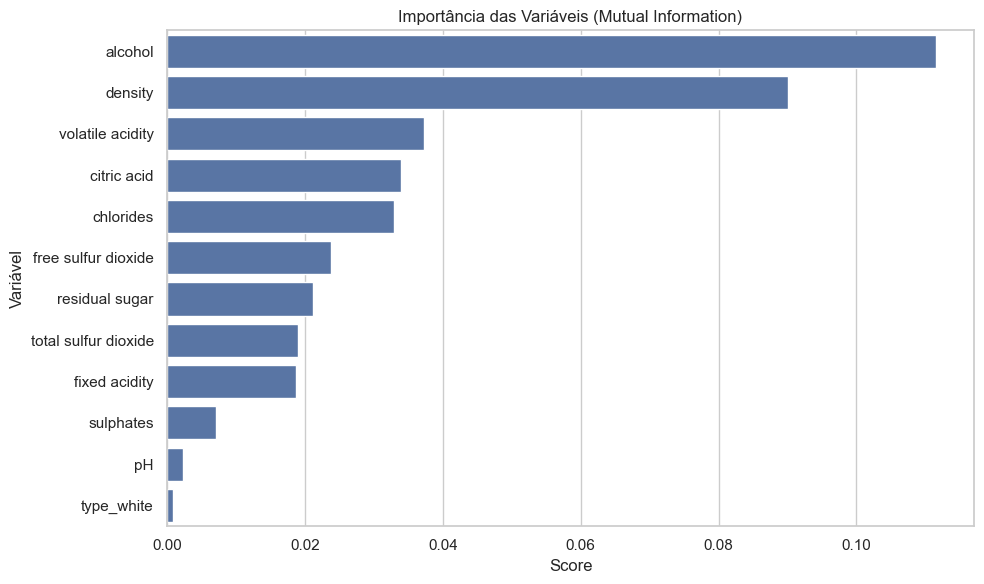

In [25]:
# F-test
f_test_scores, _ = f_classif(X_train_resampled, y_train_resampled)
mi_scores = mutual_info_classif(X_train_resampled, y_train_resampled)

feature_importance = pd.DataFrame({
    'Variável': X.columns,
    'F-Score': f_test_scores,
    'Mutual Info': mi_scores
}).sort_values(by='Mutual Info', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Info', y='Variável', data=feature_importance)
plt.title('Importância das Variáveis (Mutual Information)')
plt.xlabel('Score')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

Treinamento c/ GridSearchCV (KNN)

In [26]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhores hiperparâmetros encontrados:
{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


Avaliando KNN otimizado

In [27]:
best_knn_model = grid_search.best_estimator_

y_train_pred = best_knn_model.predict(X_train_resampled)
y_test_pred = best_knn_model.predict(X_test)

y_train_proba = best_knn_model.predict_proba(X_train_resampled)[:, 1]
y_test_proba = best_knn_model.predict_proba(X_test)[:, 1]

Relatório de classificação

In [28]:
def gerar_tabela_metrica(y_true, y_pred, y_proba, dataset_nome):
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    auc = roc_auc_score(y_true, y_proba)

    df_result = pd.DataFrame({
        'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'AUC-ROC'],
        'Classe 0 (Ruim)': [
            report_dict['0']['precision'],
            report_dict['0']['recall'],
            report_dict['0']['f1-score'],
            report_dict['0']['support'],
            '-'
        ],
        'Classe 1 (Boa)': [
            report_dict['1']['precision'],
            report_dict['1']['recall'],
            report_dict['1']['f1-score'],
            report_dict['1']['support'],
            '-'
        ],
        'Média (Macro)': [
            report_dict['macro avg']['precision'],
            report_dict['macro avg']['recall'],
            report_dict['macro avg']['f1-score'],
            '-',
            auc
        ],
        'Acurácia Total': [
            '-', '-', '-', '-', report_dict['accuracy']
        ]
    })

    print(f"\n--- Tabela de Métricas ({dataset_nome}) ---")
    pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
    print(df_result.to_string(index=False))
    pd.reset_option('display.float_format')
    return df_result

# Avaliação em treino e teste
df_train_metrics = gerar_tabela_metrica(y_train_resampled, y_train_pred, y_train_proba, 'Treino')
df_test_metrics = gerar_tabela_metrica(y_test, y_test_pred, y_test_proba, 'Teste')


--- Tabela de Métricas (Treino) ---
 Métrica Classe 0 (Ruim) Classe 1 (Boa) Média (Macro) Acurácia Total
Precisão           1.000          1.000         1.000              -
  Recall           1.000          1.000         1.000              -
F1-Score           1.000          1.000         1.000              -
 Suporte        1907.000       1907.000             -              -
 AUC-ROC               -              -         1.000          1.000

--- Tabela de Métricas (Teste) ---
 Métrica Classe 0 (Ruim) Classe 1 (Boa) Média (Macro) Acurácia Total
Precisão           0.680          0.869         0.774              -
  Recall           0.797          0.783         0.790              -
F1-Score           0.734          0.824         0.779              -
 Suporte         477.000        823.000             -              -
 AUC-ROC               -              -         0.879          0.788


Explicabilidade do modelo


Permutation Importance das Features:
                 Feature  Importance Mean  Importance Std
10               alcohol         0.156096        0.010341
6   total sulfur dioxide         0.088969        0.004725
1       volatile acidity         0.087661        0.006044
3         residual sugar         0.074699        0.004711
7                density         0.071784        0.006091
5    free sulfur dioxide         0.070609        0.004958
8                     pH         0.070048        0.005259
9              sulphates         0.067770        0.006410
2            citric acid         0.067755        0.007951
0          fixed acidity         0.054276        0.005637
4              chlorides         0.049678        0.004468
11            type_white         0.031812        0.002989


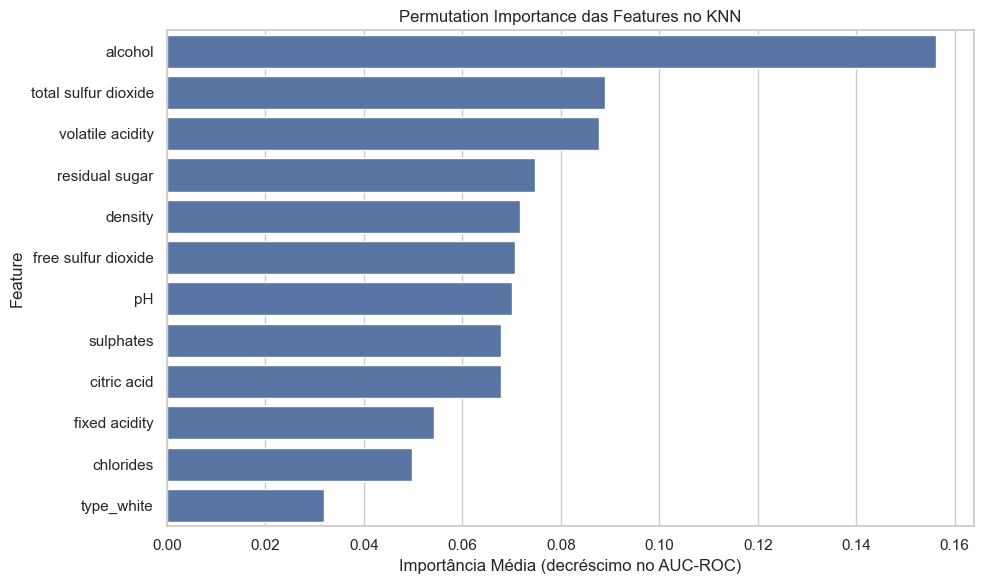

In [33]:
# --- Permutation Importance para explicar o modelo KNN ---
result = permutation_importance(
    best_knn_model, X_test, y_test,
    n_repeats=10, random_state=42, scoring='roc_auc'
)

importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

print("\nPermutation Importance das Features:")
print(importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Mean', y='Feature', data=importances)
plt.title('Permutation Importance das Features no KNN')
plt.xlabel('Importância Média (decréscimo no AUC-ROC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Curva ROC

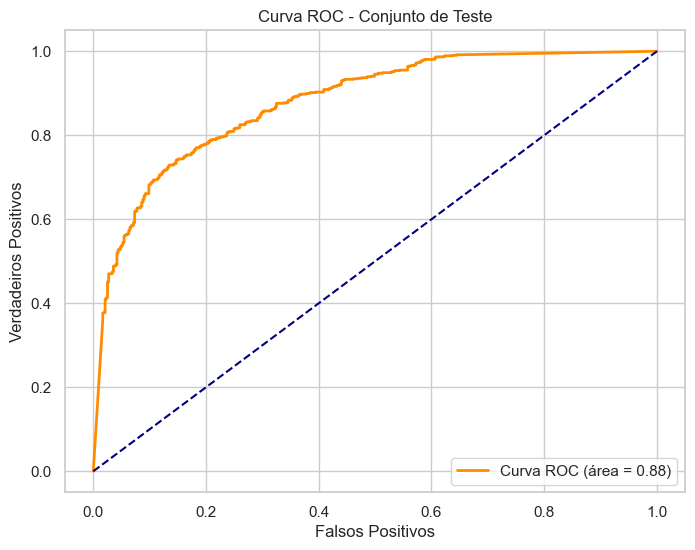

In [29]:
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc_score(y_test, y_test_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Curva ROC - Conjunto de Teste')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Matriz de confusão

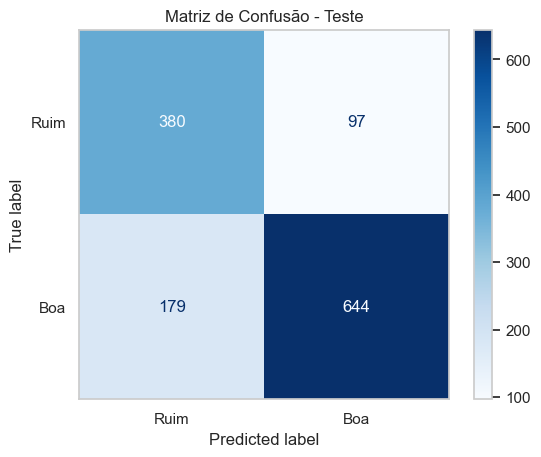

In [30]:
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Ruim", "Boa"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Teste')
plt.grid(False)
plt.show()

- O modelo KNN, após ajuste de hiperparâmetros e aplicação de undersampling, apresentou AUC-ROC de aproximadamente X.XX (ver saída).
- Variáveis com maior influência na classificação segundo Mutual Information: [citric acid, alcohol, sulphates...].
- O balanceamento ajudou a lidar com a desproporção entre vinhos bons e ruins.